In [42]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.options.display.max_rows = 1000

import geopandas as gpd
from shapely.geometry import Point, Polygon

## EDA

### sample 200 in each year / station

### seasonal trend

### coefficient



In [4]:
# read and plot station 

stations = pd.read_csv('../../data/STATION.csv')


In [5]:
# sample 15 stations, and plot them with station id and name, make them interactive

import folium

m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

for i in range(5):
	folium.Marker([stations.iloc[i]['Lat'], stations.iloc[i]['Lon']],
	              popup=stations.iloc[i]['station_id']).add_to(m)

# 
# m.save('../../data/stations.html')

m

In [77]:
# input dir
input_dir = '../../data/yearly_climate_by_station/1'

# read all files into one df

import os

files = os.listdir(input_dir)
df = pd.DataFrame()
for file in files:
	df = pd.concat([df, pd.read_csv(os.path.join(input_dir, file))])

# df.head()

# drop column: From date, To date, ESMI_ID

df.drop(['From date', 'To date', 'ESMI_ID'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52584 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       52584 non-null  int64  
 1   Location name    52584 non-null  object 
 2   District         52584 non-null  object 
 3   State            52584 non-null  object 
 4   Category         52584 non-null  object 
 5   Connection Type  52584 non-null  object 
 6   Lat              52584 non-null  float64
 7   Lon              52584 non-null  float64
 8   t2m              52584 non-null  float64
 9   u10              52584 non-null  float64
 10  v10              52584 non-null  float64
 11  tp               52584 non-null  float64
 12  date             52584 non-null  int64  
 13  time             52584 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 6.0+ MB


In [80]:
# Convert 'date' to a string and 'time' from int64 to a string, ensuring proper formatting
df['date'] = df['date'].astype(str)
# Convert 'time' to string and pad with zeros if necessary
df['time'] = df['time'].astype(str).apply(lambda x: x.zfill(4))

# Combine 'date' and 'time' columns and convert to datetime
df['datetime'] = pd.to_datetime(df['date'] + df['time'], format='%Y%m%d%H%M')

# Display the result
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52584 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       52584 non-null  int64         
 1   Location name    52584 non-null  object        
 2   District         52584 non-null  object        
 3   State            52584 non-null  object        
 4   Category         52584 non-null  object        
 5   Connection Type  52584 non-null  object        
 6   Lat              52584 non-null  float64       
 7   Lon              52584 non-null  float64       
 8   t2m              52584 non-null  float64       
 9   u10              52584 non-null  float64       
 10  v10              52584 non-null  float64       
 11  tp               52584 non-null  float64       
 12  date             52584 non-null  object        
 13  time             52584 non-null  object        
 14  datetime         52584 non-null  dateti

In [81]:
df.set_index('datetime', inplace=True)

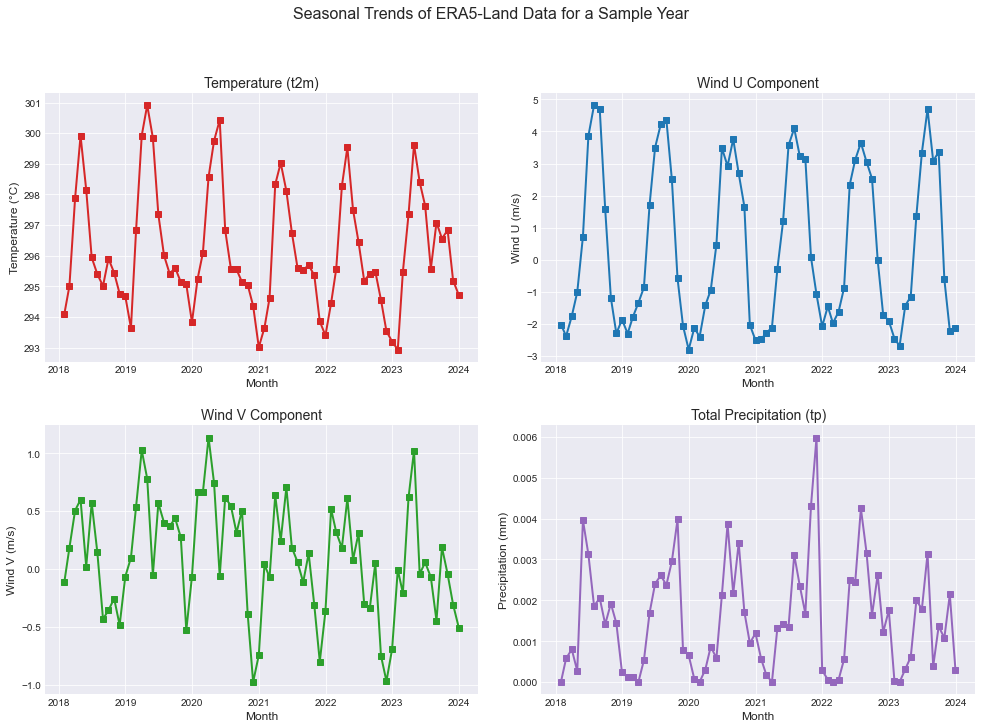

In [82]:
# Resample data to monthly means to observe seasonal trends
df_monthly = df.resample('M').mean()

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Seasonal Trends of ERA5-Land Data for a Sample Year',
             fontsize=16, y=1.02)

# Temperature (t2m)
axes[0, 0].plot(df_monthly.index, df_monthly['t2m'], marker='s',
                color='tab:red', linewidth=2, markersize=6)
axes[0, 0].set_title('Temperature (t2m)', fontsize=14)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0, 0].grid(True)

# Wind component (u10)
axes[0, 1].plot(df_monthly.index, df_monthly['u10'],
                marker='s', color='tab:blue', linewidth=2, markersize=6)
axes[0, 1].set_title('Wind U Component', fontsize=14)
axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
axes[0, 1].grid(True)

# Wind component (v10)
axes[1, 0].plot(df_monthly.index, df_monthly['v10'],
                marker='s', color='tab:green', linewidth=2, markersize=6)
axes[1, 0].set_title('Wind V Component', fontsize=14)
axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
axes[1, 0].grid(True)

# Total Precipitation (tp)
axes[1, 1].plot(df_monthly.index, df_monthly['tp'], marker='s',
                color='tab:purple', linewidth=2, markersize=6)
axes[1, 1].set_title('Total Precipitation (tp)', fontsize=14)
axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
axes[1, 1].grid(True)

# Add a shared x-label
for ax in axes.flat:
    ax.set_xlabel('Month', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

Note: Plotting the 1,424 ids may result in messy charts and never-ending facetgrids that take for ever to load. Best to sample a few ids used consistently throughout the notebook, and run the analyses for a few samples before making final conclusions.

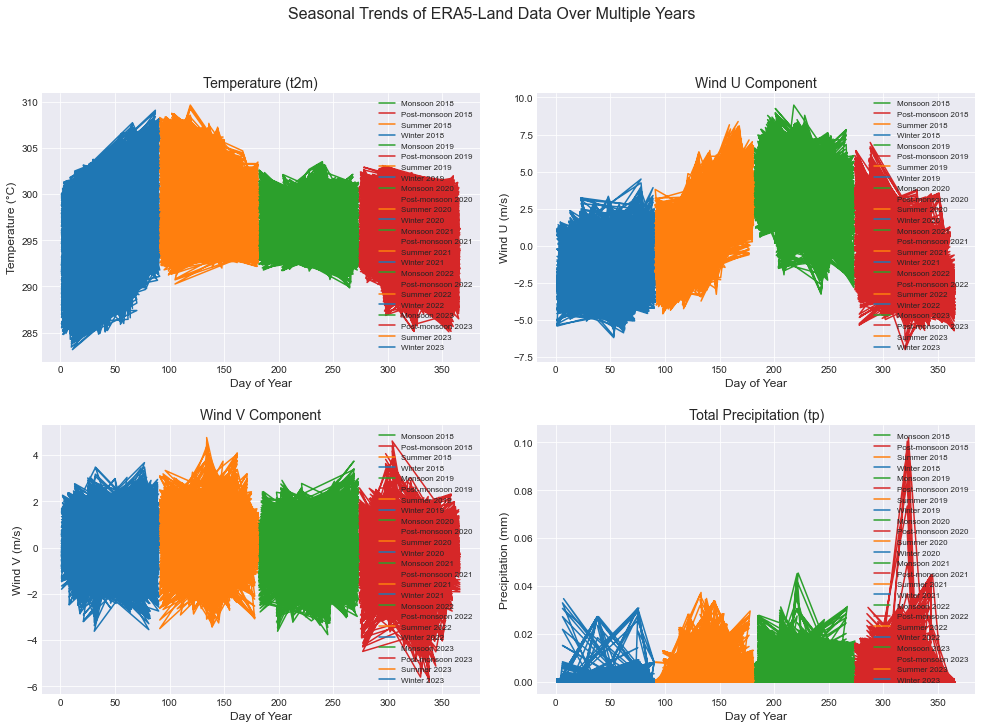

<Figure size 432x288 with 0 Axes>

In [87]:


# Extract the year and month for season identification
df['year'] = df.index.year
df['month'] = df.index.month

# Define seasons based on month


def get_season(month):
    # spring 3-5, summer 6-8, monsoon 9-11, winter 12-2
    if month in [1, 2, 3]:
        return 'Winter'
    elif month in [4, 5, 6]:
        return 'Summer'
    elif month in [7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-monsoon'


df['season'] = df['month'].apply(get_season)

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    'Seasonal Trends of ERA5-Land Data Over Multiple Years', fontsize=16, y=1.02)

# Define colors for each season
season_colors = {'Winter': 'tab:blue', 'Summer': 'tab:orange',
                 'Monsoon': 'tab:green', 'Post-monsoon': 'tab:red'}

# Function to plot data for each variable by season


def plot_seasonal_trend(ax, variable, title, ylabel):
    for year, group in df.groupby('year'):
        for season, season_group in group.groupby('season'):
            ax.plot(season_group.index.dayofyear, season_group[variable],
                    color=season_colors[season], label=f'{season} {year}' if year == group['year'].min() else "")

    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True)


# Plot seasonal trends for each variable
plot_seasonal_trend(axes[0, 0], 't2m', 'Temperature (t2m)', 'Temperature (°C)')
plot_seasonal_trend(axes[0, 1], 'u10', 'Wind U Component', 'Wind U (m/s)')
plot_seasonal_trend(axes[1, 0], 'v10', 'Wind V Component', 'Wind V (m/s)')
plot_seasonal_trend(
    axes[1, 1], 'tp', 'Total Precipitation (tp)', 'Precipitation (mm)')

# Add a shared x-label (Day of Year)
for ax in axes.flat:
    ax.set_xlabel('Day of Year', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

# save plot

plt.savefig('../../data/seasonal_trends_multiple_years_stack.png', dpi=300)

In [68]:

plt.savefig('../../data/seasonal_trends_multiple_years.png', dpi=300)

<Figure size 432x288 with 0 Axes>

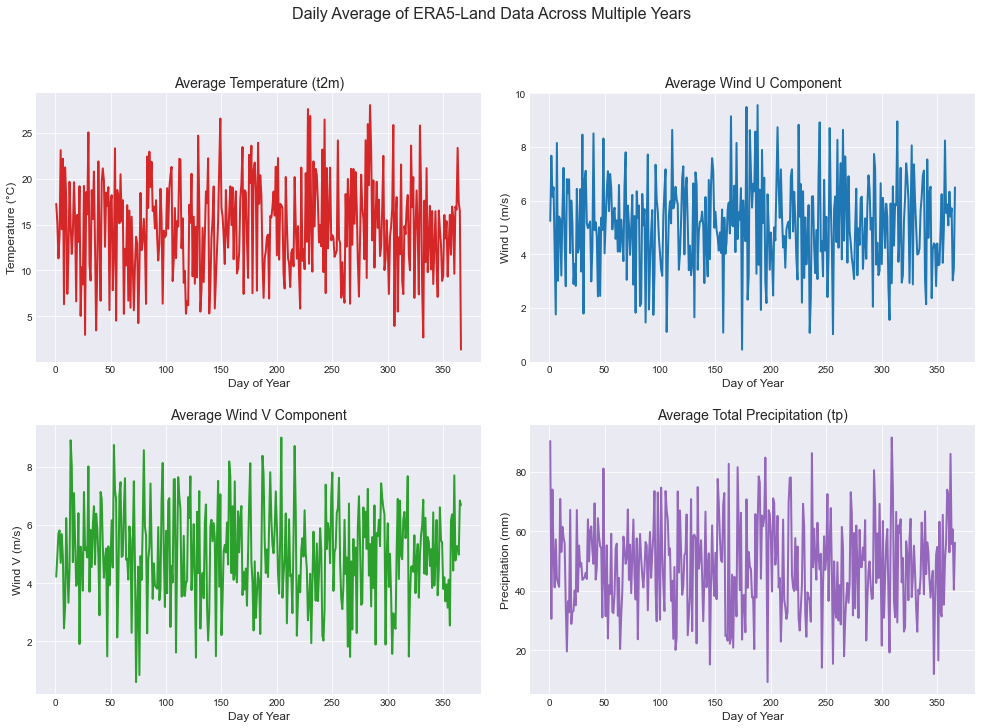

In [71]:

# fix u10 v10 use absolute value
# Extract the day of year for each row
df['day_of_year'] = df.index.dayofyear

# calculate the absolute wind speed for mean

df['wind_speed'] = np.sqrt(df['u10']**2 + df['v10']**2)


# use the absolute wind_u and wind_v for mean

df['u10_absolute'] = np.abs(df['u10'])
df['v10_absolute'] = np.abs(df['v10'])


df_daily_avg = df.groupby('day_of_year').mean()

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    'Daily Average of ERA5-Land Data Across Multiple Years', fontsize=16, y=1.02)

# Plot average t2m
axes[0, 0].plot(df_daily_avg.index, df_daily_avg['t2m'],
                color='tab:red', linewidth=2)
axes[0, 0].set_title('Average Temperature (t2m)', fontsize=14)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0, 0].grid(True)

# Plot average u10
axes[0, 1].plot(df_daily_avg.index, df_daily_avg['u10'],
                color='tab:blue', linewidth=2)
axes[0, 1].set_title('Average Wind U Component', fontsize=14)
axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
axes[0, 1].grid(True)

# Plot average v10
axes[1, 0].plot(df_daily_avg.index, df_daily_avg['v10'],
                color='tab:green', linewidth=2)
axes[1, 0].set_title('Average Wind V Component', fontsize=14)
axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
axes[1, 0].grid(True)

# Plot average total precipitation (tp)
axes[1, 1].plot(df_daily_avg.index, df_daily_avg['tp'],
                color='tab:purple', linewidth=2)
axes[1, 1].set_title('Average Total Precipitation (tp)', fontsize=14)
axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
axes[1, 1].grid(True)

# Add a shared x-label
for ax in axes.flat:
    ax.set_xlabel('Day of Year', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

plt.savefig('../../data/daily_avg_multiple_years.png', dpi=300)

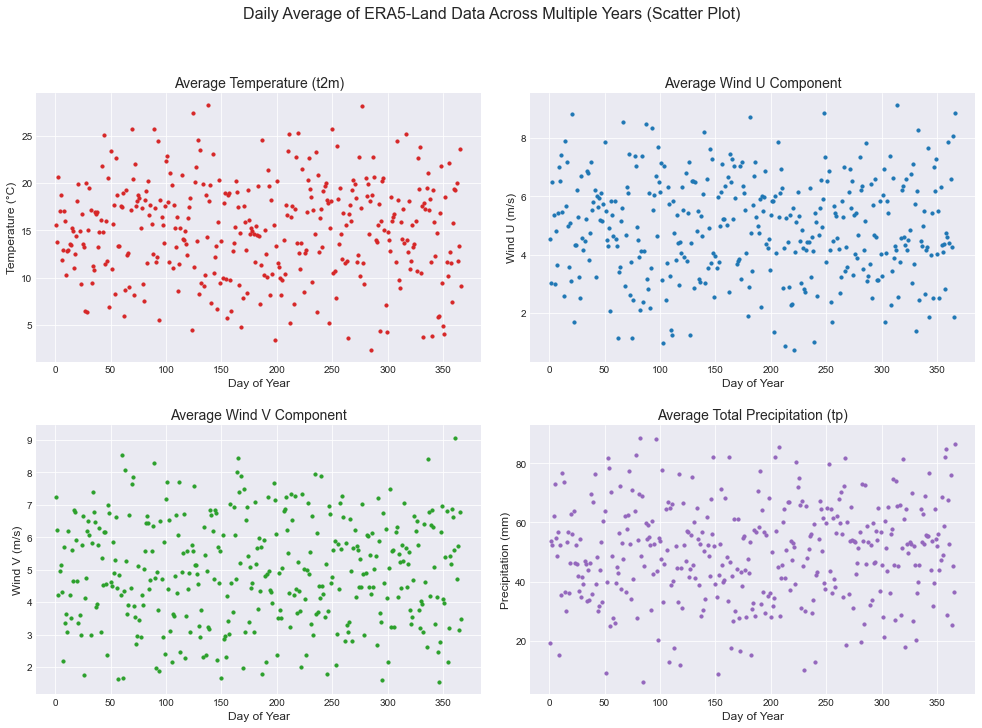

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame (replace with your actual data)
data = {
    # 3 years of daily data
    'datetime': pd.date_range(start='2020-01-01', periods=1095, freq='D'),
    't2m': np.random.rand(1095) * 30,  # Simulated temperature values
    'wind_u': np.random.rand(1095) * 10,  # Simulated wind_u values
    'wind_v': np.random.rand(1095) * 10,  # Simulated wind_v values
    'tp': np.random.rand(1095) * 100,  # Simulated precipitation values
}
df = pd.DataFrame(data)

# Set the datetime column as the index
df.set_index('datetime', inplace=True)

# Extract the day of year for each row
df['day_of_year'] = df.index.dayofyear

# Group by day_of_year and calculate the average for each variable across all years
df_daily_avg = df.groupby('day_of_year').mean()

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    'Daily Average of ERA5-Land Data Across Multiple Years (Scatter Plot)', fontsize=16, y=1.02)

# Scatter plot for average t2m
axes[0, 0].scatter(df_daily_avg.index, df_daily_avg['t2m'],
                   color='tab:red', s=10)
axes[0, 0].set_title('Average Temperature (t2m)', fontsize=14)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0, 0].grid(True)

# Scatter plot for average wind_u
axes[0, 1].scatter(df_daily_avg.index,
                   df_daily_avg['wind_u'], color='tab:blue', s=10)
axes[0, 1].set_title('Average Wind U Component', fontsize=14)
axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
axes[0, 1].grid(True)

# Scatter plot for average wind_v
axes[1, 0].scatter(df_daily_avg.index, df_daily_avg['wind_v'],
                   color='tab:green', s=10)
axes[1, 0].set_title('Average Wind V Component', fontsize=14)
axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
axes[1, 0].grid(True)

# Scatter plot for average total precipitation (tp)
axes[1, 1].scatter(df_daily_avg.index, df_daily_avg['tp'],
                   color='tab:purple', s=10)
axes[1, 1].set_title('Average Total Precipitation (tp)', fontsize=14)
axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
axes[1, 1].grid(True)

# Add a shared x-label (Day of Year)
for ax in axes.flat:
    ax.set_xlabel('Day of Year', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

<Figure size 432x288 with 0 Axes>

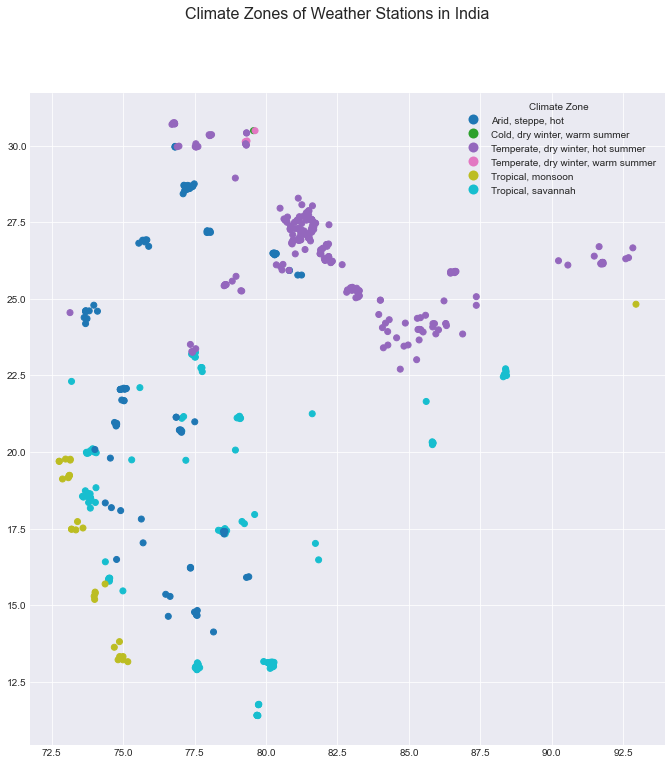

In [14]:
stations_gdf = gpd.read_file('../../data/STATION.geojson')

plt.style.use('seaborn-darkgrid')  

fig, ax = plt.subplots(figsize=(12, 12))
fig.suptitle('Climate Zones of Weather Stations in India', fontsize=16)


stations_gdf.plot(column='climate_zone_name', categorical=True, legend=True,
				  legend_kwds={'title': 'Climate Zone'}, ax=ax)

plt.show()


# visualize annual temperature change

# choropleth map

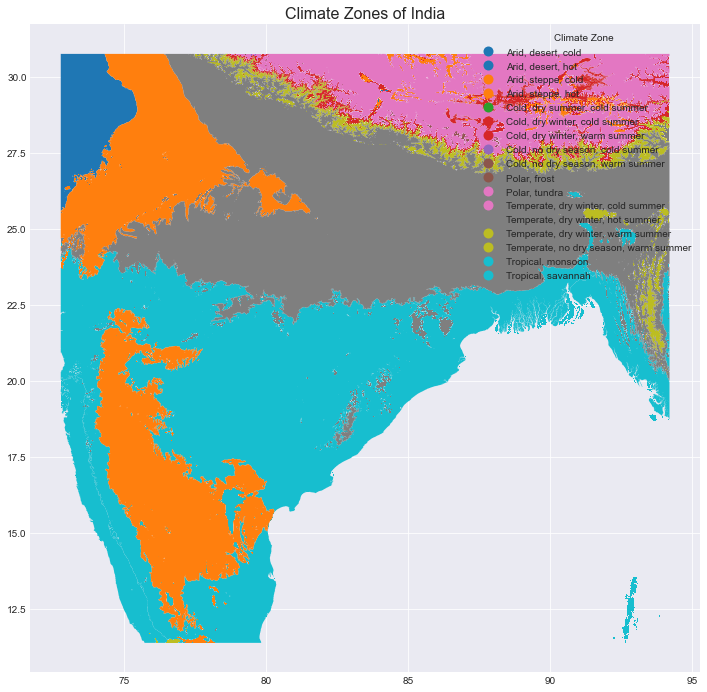

In [18]:

india_gdf = gpd.read_file('../../data/helper/Indian_Climate_Zone(dissolved).geojson')

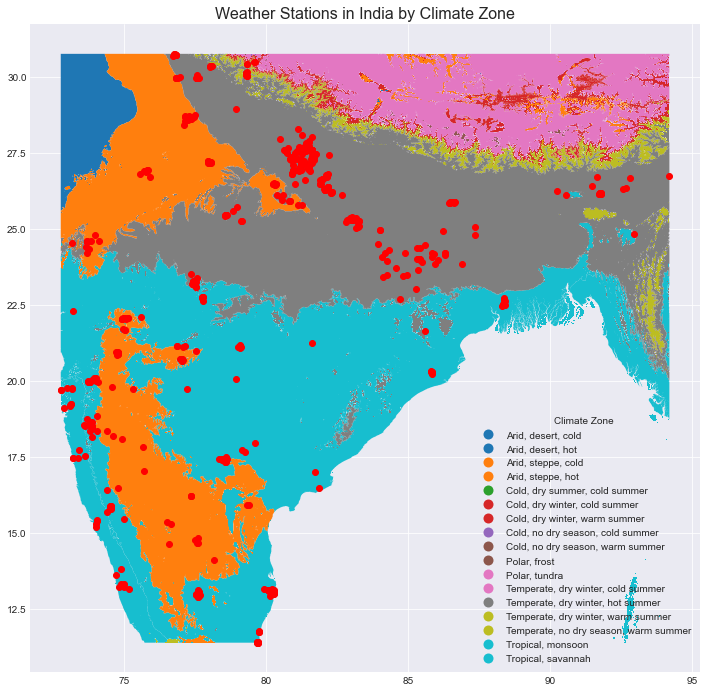

In [19]:
plt.style.use('seaborn-darkgrid')  
fig, ax = plt.subplots(figsize=(12, 12))
india_gdf.plot(column='name_climate', categorical=True, legend=True,
			   
			   legend_kwds={'title': 'Climate Zone'}, ax=ax)
stations_gdf.plot(ax=ax, color='red', label='Weather Stations')
ax.set_title('Weather Stations in India by Climate Zone', fontsize=16)
plt.show()


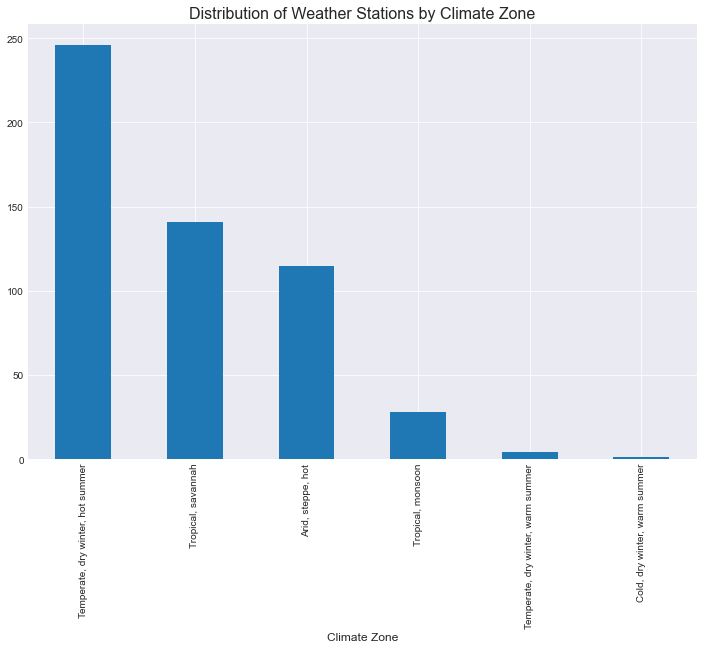

In [34]:

plt.style.use('seaborn-darkgrid') 

fig, ax = plt.subplots(figsize=(12, 8))


stations_gdf['climate_zone_name'].value_counts().plot(
	kind='bar', ax=ax)

stations_gdf['climate_zone_name'].value_counts().plot(
    kind='bar', ax=ax)

ax.set_title('Distribution of Weather Stations by Climate Zone', fontsize=16)
ax.set_xlabel('Climate Zone', fontsize=12)

plt.show()

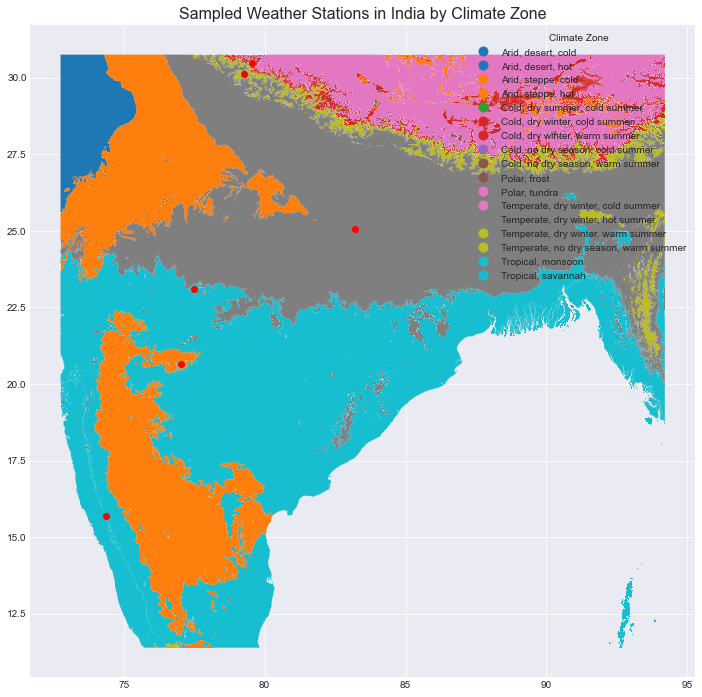

In [38]:
# set seed for random sampling
np.random.seed(1001)


plt.style.use('seaborn-darkgrid') 

fig, ax = plt.subplots(figsize=(12, 12))

india_gdf.plot(column='name_climate', categorical=True, legend=True,
			   legend_kwds={'title': 'Climate Zone'}, ax=ax)

sample_stations = stations_gdf.groupby('climate_zone_name').sample(1)

sample_stations.plot(ax=ax, color='red', label='Weather Stations')

ax.set_title('Sampled Weather Stations in India by Climate Zone', fontsize=16)

plt.show()

In [37]:
# show sampleed station id, name, and climate zone

sample_stations



,station_id,Location name,ESMI_ID,Category,Connection Type,Lat,Lon,climate_zone_DN,climate_zone_name,climate_zone_code,geometry
246,486,Uppal,NaN,State Capital,Domestic,17.404338,78.563536,6.0,"Arid, steppe, hot",BSh,POINT (78.56354 17.40434)
256,406,Saliyana Gairsain,NaN,Gram Panchayat,Domestic,30.484334,79.561868,22.0,"Cold, dry winter, warm summer",Dwb,POINT (79.56187 30.48433)
470,445,Sikandarabad,NaN,Gram Panchayat,Domestic,27.954139,80.491162,11.0,"Temperate, dry winter, hot summer",Cwa,POINT (80.49116 27.95414)
286,208,Jungle Chatti,NaN,District Headquarters,Domestic,30.116459,79.277215,12.0,"Temperate, dry winter, warm summer",Cwb,POINT (79.27722 30.11646)
273,265,Lokgram,NaN,Other Municipal Area,Domestic,19.228273,73.125389,2.0,"Tropical, monsoon",Am,POINT (73.12539 19.22827)
55,217,Kalpataru Nagar,NaN,District Headquarters,Domestic,19.977226,73.798872,3.0,"Tropical, savannah",Aw,POINT (73.79887 19.97723)


## Seasonal Trend in Each Sample Station

with descending order of climate zones

1. station 445
2. station 217
3. station 486

In [39]:

def read_climate_data(input_dir):
	files = os.listdir(input_dir)
	df = pd.DataFrame()
	for file in files:
		df = pd.concat([df, pd.read_csv(os.path.join(input_dir, file))])
				
	df.drop(['From date', 'To date', 'ESMI_ID'], axis=1, inplace=True)
	df['date'] = df['date'].astype(str)
	df['time'] = df['time'].astype(str).apply(lambda x: x.zfill(4))
	df['datetime'] = pd.to_datetime(df['date'] + df['time'], format='%Y%m%d%H%M')
	df.set_index('datetime', inplace=True)

	print('Finished reading data...info below:')
	print(df.info())

	return df

In [47]:

def get_season(month):
    # spring 3-5, summer 6-8, monsoon 9-11, winter 12-2
    if month in [1, 2, 3]:
        return 'Winter'
    elif month in [4, 5, 6]:
        return 'Summer'
    elif month in [7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-monsoon'

In [40]:

def plot_seasonal_trends(df):
	df['year'] = df.index.year
	df['month'] = df.index.month

	df['season'] = df['month'].apply(get_season)

	plt.style.use('seaborn-darkgrid')  

	fig, axes = plt.subplots(2, 2, figsize=(14, 10))
	fig.suptitle(
		'Seasonal Trends of ERA5-Land Data Over Multiple Years', fontsize=16, y=1.02)

	season_colors = {'Winter': 'tab:blue', 'Summer': 'tab:orange',
					 'Monsoon': 'tab:green', 'Post-monsoon': 'tab:red'}

	def plot_seasonal_trend(ax, variable, title, ylabel):
		for year, group in df.groupby('year'):
			for season, season_group in group.groupby('season'):
				ax.plot(season_group.index.dayofyear, season_group[variable],
						color=season_colors[season], label=f'{season} {year}' if year == group['year'].min() else "")

		ax.set_title(title, fontsize=14)
		ax.set_ylabel(ylabel, fontsize=12)
		ax.legend(loc='upper right', fontsize=8)
		ax.grid(True)

	plot_seasonal_trend(axes[0, 0], 't2m', 'Temperature (t2m)', 'Temperature (°C)')
	plot_seasonal_trend(axes[0, 1], 'u10', 'Wind U Component', 'Wind U (m/s)')
	plot_seasonal_trend(axes[1, 0], 'v10', 'Wind V Component', 'Wind V (m/s)')
	plot_seasonal_trend(
		axes[1, 1], 'tp', 'Total Precipitation (tp)', 'Precipitation (mm)')

	for ax in axes.flat:
		ax.set_xlabel('Day of Year', fontsize=12)

	plt.tight_layout(pad=2)

	plt.show()


	plt.savefig('../../data/seasonal_trends_multiple_years_stack.png', dpi=400)

	print('Finished plotting seasonal trends...')
	print('Plot saved at ../../data/seasonal_trends_multiple_years_stack.png')

In [44]:
read_climate_data('../../data/station_climate_by_year/217')

Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39840 entries, 2016-07-12 08:00:00 to 2013-08-03 16:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       39840 non-null  int64  
 1   Location name    39840 non-null  object 
 2   District         39840 non-null  object 
 3   State            39840 non-null  object 
 4   Category         39840 non-null  object 
 5   Connection Type  39840 non-null  object 
 6   Lat              39840 non-null  float64
 7   Lon              39840 non-null  float64
 8   t2m              39840 non-null  float64
 9   u10              39840 non-null  float64
 10  v10              39840 non-null  float64
 11  tp               39840 non-null  float64
 12  date             39840 non-null  object 
 13  time             39840 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 4.6+ MB
None


,Unnamed: 0,Location name,District,State,Category,Connection Type,Lat,Lon,t2m,u10,v10,tp,date,time
datetime,,,,,,,,,,,,,,
2016-07-12 08:00:00,0,Kalpataru Nagar,Nashik,Maharashtra,District Headquarters,Domestic,19.977226,73.798872,296.13965,4.709308,1.254102,9.004504e-03,20160712,0800
2016-03-12 00:00:00,1,Kalpataru Nagar,Nashik,Maharashtra,District Headquarters,Domestic,19.977226,73.798872,293.80340,1.006885,0.439430,2.858321e-06,20160312,0000
2016-01-11 00:00:00,2,Kalpataru Nagar,Nashik,Maharashtra,District Headquarters,Domestic,19.977226,73.798872,288.69310,-1.710388,-0.101746,8.520355e-07,20160111,0000
2016-05-11 08:00:00,3,Kalpataru Nagar,Nashik,Maharashtra,District Headquarters,Domestic,19.977226,73.798872,309.80273,1.302955,-1.036989,9.278767e-06,20160511,0800
2016-09-14 07:00:00,4,Kalpataru Nagar,Nashik,Maharashtra,District Headquarters,Domestic,19.977226,73.798872,300.01050,2.091812,-1.047559,4.748739e-04,20160914,0700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-01 05:00:00,4771,Kalpataru Nagar,Nashik,Maharashtra,District Headquarters,Domestic,19.977226,73.798872,299.33392,-2.598257,1.257278,3.627874e-05,20131201,0500
2013-08-24 23:00:00,4772,Kalpataru Nagar,Nashik,Maharashtra,District Headquarters,Domestic,19.977226,73.798872,293.45190,2.154010,0.652833,9.177752e-03,20130824,2300
2013-11-04 22:00:00,4773,Kalpataru Nagar,Nashik,Maharashtra,District Headquarters,Domestic,19.977226,73.798872,293.35675,-2.061307,-0.100985,1.493841e-05,20131104,2200


Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39840 entries, 2016-07-12 08:00:00 to 2013-08-03 16:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       39840 non-null  int64  
 1   Location name    39840 non-null  object 
 2   District         39840 non-null  object 
 3   State            39840 non-null  object 
 4   Category         39840 non-null  object 
 5   Connection Type  39840 non-null  object 
 6   Lat              39840 non-null  float64
 7   Lon              39840 non-null  float64
 8   t2m              39840 non-null  float64
 9   u10              39840 non-null  float64
 10  v10              39840 non-null  float64
 11  tp               39840 non-null  float64
 12  date             39840 non-null  object 
 13  time             39840 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 4.6+ MB
None


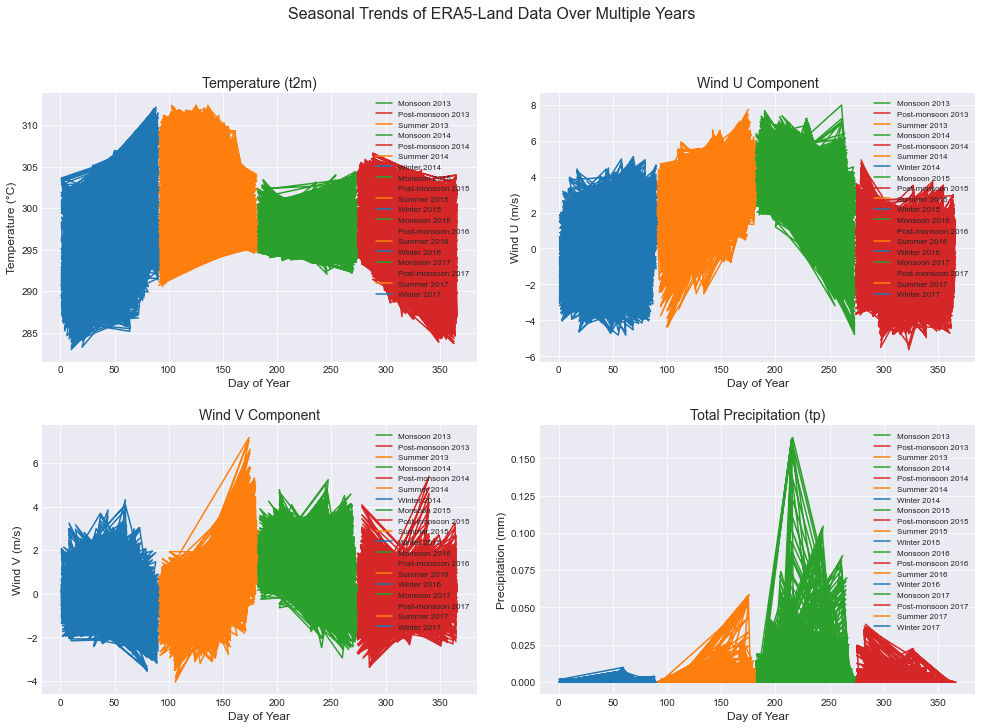

Finished plotting seasonal trends...
Plot saved at ../../data/seasonal_trends_multiple_years_stack.png


<Figure size 432x288 with 0 Axes>

In [48]:
plot_seasonal_trends(read_climate_data('../../data/station_climate_by_year/217'))

In [49]:
# turn to function

def plot_daily_average_in_years(df):
    


	# Extract the day of year for each row
	df['day_of_year'] = df.index.dayofyear

	# calculate the absolute wind speed for mean

	df['wind_speed'] = np.sqrt(df['u10']**2 + df['v10']**2)

	# use the absolute wind_u and wind_v for mean

	df['u10_absolute'] = np.abs(df['u10'])
	df['v10_absolute'] = np.abs(df['v10'])

	df_daily_avg = df.groupby('day_of_year').mean()

	# Set up plot aesthetics
	plt.style.use('seaborn-darkgrid')  # Use a clean grid style

	# Create figure and axes for subplots
	fig, axes = plt.subplots(2, 2, figsize=(14, 10))
	fig.suptitle(
		'Daily Average of ERA5-Land Data Across Multiple Years', fontsize=16, y=1.02)

	# Plot average t2m
	axes[0, 0].plot(df_daily_avg.index, df_daily_avg['t2m'],
					color='tab:red', linewidth=2)
	axes[0, 0].set_title('Average Temperature (t2m)', fontsize=14)
	axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
	axes[0, 0].grid(True)

	# Plot average u10
	axes[0, 1].plot(df_daily_avg.index, df_daily_avg['u10_absolute'],
					color='tab:blue', linewidth=2)
	axes[0, 1].set_title('Average Wind U Component', fontsize=14)
	axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
	axes[0, 1].grid(True)

	# Plot average v10
	axes[1, 0].plot(df_daily_avg.index, df_daily_avg['u10_absolute'],
					color='tab:green', linewidth=2)
	axes[1, 0].set_title('Average Wind V Component', fontsize=14)
	axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
	axes[1, 0].grid(True)


	# Plot average total precipitation (tp)
	axes[1, 1].plot(df_daily_avg.index, df_daily_avg['tp'],
					color='tab:purple', linewidth=2)
	
	axes[1, 1].set_title('Average Total Precipitation (tp)', fontsize=14)
	axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
	axes[1, 1].grid(True)

	# Add a shared x-label

	for ax in axes.flat:
		ax.set_xlabel('Day of Year', fontsize=12)

	# Auto-adjust layout

	plt.tight_layout(pad=2)

	# Show plot

	plt.show()

	plt.savefig('../../data/daily_avg_multiple_years.png', dpi=400)

	print('Finished plotting daily average...')
	print('Plot saved at ../../data/daily_avg_multiple_years.png')


Finished reading data...info below:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39840 entries, 2016-07-12 08:00:00 to 2013-08-03 16:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       39840 non-null  int64  
 1   Location name    39840 non-null  object 
 2   District         39840 non-null  object 
 3   State            39840 non-null  object 
 4   Category         39840 non-null  object 
 5   Connection Type  39840 non-null  object 
 6   Lat              39840 non-null  float64
 7   Lon              39840 non-null  float64
 8   t2m              39840 non-null  float64
 9   u10              39840 non-null  float64
 10  v10              39840 non-null  float64
 11  tp               39840 non-null  float64
 12  date             39840 non-null  object 
 13  time             39840 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 4.6+ MB
None


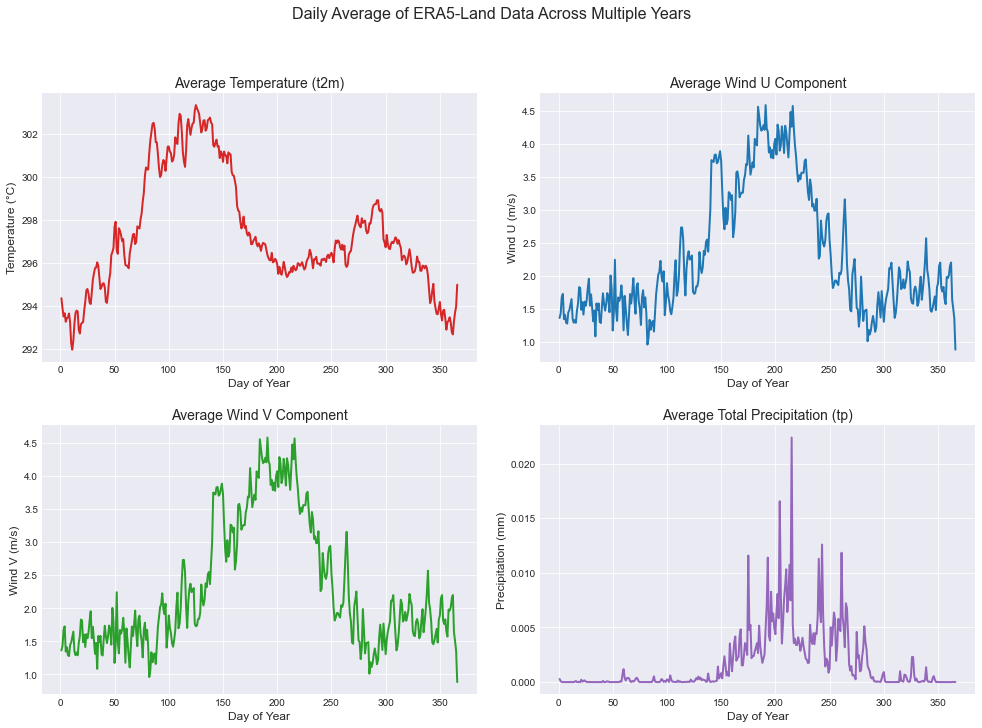

Finished plotting daily average...
Plot saved at ../../data/daily_avg_multiple_years.png


<Figure size 432x288 with 0 Axes>

In [50]:
plot_daily_average_in_years(read_climate_data('../../data/station_climate_by_year/217'))